In [2]:
#initializing node structure
import chess
import chess.pgn
import chess.engine
import random
import time
import numpy as np
from math import log,sqrt,e,inf
from IPython.display import display, HTML, clear_output
engine = chess.engine.SimpleEngine.popen_uci(r'stockfish-11-win/Windows/stockfish_20011801_x64.exe')

#engine = chess.engine.SimpleEngine.popen_uci("stockfish")


class node:
    def __init__(self,*board):
        if(len(board)>0):
            self.state = board
        else:
            self.state = chess.Board()
        self.action = ''
        self.children = set()
        self.parent = None
        self.N = 0
        self.n = 0
        self.v = 0

In [3]:
#method for ucb and AI rollout
def ucb1(curr_node):
    ans = curr_node.v+2*(sqrt(log(curr_node.N+e+(10**-6))/(curr_node.n+(10**-10))))
    return ans

def rollout(board,curr_node):
    global engine
    if(curr_node.state.is_game_over()):
        board1 = curr_node.state
        if(board1.result()=='1-0'):
            return (1,curr_node)
        elif(board1.result()=='0-1'):
            return (-1,curr_node)
        else:
            return (0.5,curr_node)
    
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    result = engine.play(curr_node.state, chess.engine.Limit(time=0.001))
    move = curr_node.state.san(result.move)
    tmp_state = chess.Board(curr_node.state.fen())
    tmp_state.push_san(move)

    to_use = None
    
    for i in all_moves:
        tmp_state1 = chess.Board(curr_node.state.fen())
        tmp_state1.push_san(i)
        child = node()
        child.state = tmp_state1
        child.parent = curr_node
        curr_node.children.add(child)
        if(child.state==tmp_state):
            to_use = child
            break
            
    return rollout(board,to_use)





In [4]:
#method for baseline tree rollout
def rolloutTree(board,curr_node):
    
    if(curr_node.state.is_game_over()):
        board1 = curr_node.state
        if(board1.result()=='1-0'):
            return (1,curr_node)
        elif(board1.result()=='0-1'):
            return (-1,curr_node)
        else:
            return (0.5,curr_node)
    
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
    rnd_state = random.choice(list(curr_node.children))

    return rolloutTree(board,rnd_state)


In [5]:
def expand(curr_node,white):
    if(len(curr_node.children)==0):
        return curr_node
    max_ucb = -inf
    if(white):
        idx = -1
        max_ucb = -inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp>max_ucb):
                idx = i
                max_ucb = tmp
                sel_child = i

        return(expand(sel_child,0))

    else:
        idx = -1
        min_ucb = inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp<min_ucb):
                idx = i
                min_ucb = tmp
                sel_child = i

        return expand(sel_child,1)


In [6]:
def rollback(curr_node,reward):
    curr_node.n+=1
    curr_node.v+=reward
    while(curr_node.parent!=None):
        curr_node.N+=1
        curr_node = curr_node.parent
    return curr_node


In [98]:
def mcts_pred(board,curr_node,over,white,choice,base1,base2,iterations=10):
    if(over):
        return -1
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    map_state_move = dict()
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
        map_state_move[child] = i
        
    while(iterations>0):
        if(white):
            idx = -1
            max_ucb = -inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp>max_ucb):
                    idx = i
                    max_ucb = tmp
                    sel_child = i
            ex_child = expand(sel_child,0)
            if(base1=="Tree"):
                reward,state = rolloutTree(board,ex_child)
            elif(base1=="AI"):
                reward,state = rollout(board,ex_child)
            curr_node = rollback(state,reward)
            iterations-=1
        else:
            idx = -1
            min_ucb = inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp<min_ucb):
                    idx = i
                    min_ucb = tmp
                    sel_child = i

            ex_child = expand(sel_child,1)

            if(base2=="Tree"):
                reward,state = rolloutTree(board,ex_child)
            elif(base2=="AI"):
                reward,state = rollout(board,ex_child)

            curr_node = rollback(state,reward)
            iterations-=1

    if(white):
        
        mx = -inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp>mx):
                mx = tmp
                selected_move = map_state_move[i]
        return selected_move
    else:
        mn = inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp<mn):
                mn = tmp
                selected_move = map_state_move[i]
        return selected_move
    



In [8]:
def staticAnalysis(board, color):
    score = random.random()

    ## Check some things about this move:
    # score += 10 if board.is_capture(move) else 0
    # Now check some other things:
    for (piece, value) in [(chess.PAWN, 1), 
                           (chess.BISHOP, 4), 
                           (chess.KING, 0), 
                           (chess.QUEEN, 10), 
                           (chess.KNIGHT, 5),
                           (chess.ROOK, 3)]:
        score += len(board.pieces(piece, color)) * value
        score -= len(board.pieces(piece, not color)) * value
        # can also check things about the pieces position here
    # Check global things about the board
    score += 100 if board.is_checkmate() else 0
    return score



In [9]:
import os
import chess
import numpy as np
os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))
#os.chdir('C:\Users\User\Downloads\stockfish-11-win')
import chess.pgn
import pandas as pd
#https://www.kaggle.com/code/gabrielhaselhurst/chess-dataset/data
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}
csv = pd.read_csv('chessData.csv')

def make_matrix(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo
def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

import chess
import numpy as np
fen = csv['FEN'].values
values = csv['Evaluation'].values
length = 10000
X =[]
y= values[:length]
defects = []
for i in range(length):
    board = chess.Board(fen[i])
    matrix = make_matrix(board.copy())
    translated = translate(matrix,chess_dict)
    X.append(translated)
for i in range(length):
    if '#' in y[i]:
        y[i] = float(y[i][-1]) * 1000
y = y.astype('float32')

minimum = min(y)
maximum = max(y)
for i in range(len(y)):
    y[i] = (y[i]-minimum)/(maximum-minimum)
    


In [38]:
##Create and train the neural network
from keras import callbacks, optimizers
from keras.layers import (LSTM, BatchNormalization, Dense, Dropout, Flatten,
                          TimeDistributed)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, model_from_json
from IPython.display import clear_output
from matplotlib import pyplot as plt
model = Sequential()
model.add(Conv2D(filters=10, kernel_size=1, activation='relu', input_shape=(8,8,12)))
model.add(MaxPooling2D(pool_size=2, strides=None))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer = 'Adam',loss='mse')
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='val_loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=1)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
test = 1000
X = np.array(X)
X_train = X[test:]
y_train = y[test:]
X_test = X[:test]
y_test = y[:test]
model.fit(X_train,y_train,epochs = 1000,verbose = 2,validation_data = (X_test,y_test),callbacks = callback)

2022-12-17 06:18:28.823963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 06:18:41.731693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-17 06:18:41.731805: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-17 06:18:42.360789: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-17 06:19:13.099131: W tensorflow/stream_executor/platform/de

Training Network...
Epoch 1/1000
282/282 - 4s - loss: 0.0176 - val_loss: 0.0038 - 4s/epoch - 13ms/step
Epoch 2/1000
282/282 - 1s - loss: 0.0040 - val_loss: 0.0040 - 705ms/epoch - 2ms/step
Epoch 3/1000
282/282 - 1s - loss: 0.0030 - val_loss: 0.0028 - 839ms/epoch - 3ms/step
Epoch 4/1000
282/282 - 1s - loss: 0.0026 - val_loss: 0.0032 - 707ms/epoch - 3ms/step
Epoch 5/1000
282/282 - 1s - loss: 0.0025 - val_loss: 0.0030 - 690ms/epoch - 2ms/step
Epoch 6/1000
282/282 - 1s - loss: 0.0024 - val_loss: 0.0028 - 715ms/epoch - 3ms/step
Epoch 7/1000
282/282 - 1s - loss: 0.0024 - val_loss: 0.0024 - 719ms/epoch - 3ms/step
Epoch 8/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0025 - 696ms/epoch - 2ms/step
Epoch 9/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0026 - 671ms/epoch - 2ms/step
Epoch 10/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0023 - 747ms/epoch - 3ms/step
Epoch 11/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0023 - 721ms/epoch - 3ms/step
Epoch 12/1000
282/282 - 1s - loss: 0.0023 - v

Epoch 95/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0021 - 688ms/epoch - 2ms/step
Epoch 96/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0026 - 682ms/epoch - 2ms/step
Epoch 97/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 681ms/epoch - 2ms/step
Epoch 98/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0020 - 751ms/epoch - 3ms/step
Epoch 99/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 710ms/epoch - 3ms/step
Epoch 100/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 699ms/epoch - 2ms/step
Epoch 101/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0022 - 689ms/epoch - 2ms/step
Epoch 102/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 692ms/epoch - 2ms/step
Epoch 103/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 712ms/epoch - 3ms/step
Epoch 104/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 695ms/epoch - 2ms/step
Epoch 105/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0022 - 679ms/epoch - 2ms/step
Epoch 106/1000
282/282 - 1s - loss: 0.0021 - val

Epoch 190/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0023 - 680ms/epoch - 2ms/step
Epoch 191/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0023 - 676ms/epoch - 2ms/step
Epoch 192/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0020 - 666ms/epoch - 2ms/step
Epoch 193/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 663ms/epoch - 2ms/step
Epoch 194/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0023 - 668ms/epoch - 2ms/step
Epoch 195/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0021 - 673ms/epoch - 2ms/step
Epoch 196/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 674ms/epoch - 2ms/step
Epoch 197/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0020 - 666ms/epoch - 2ms/step
Epoch 198/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 701ms/epoch - 2ms/step
Epoch 199/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0021 - 699ms/epoch - 2ms/step
Epoch 200/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0020 - 716ms/epoch - 3ms/step
Epoch 201/1000
282/282 - 1s - loss: 0.0020 

282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 671ms/epoch - 2ms/step
Epoch 285/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 698ms/epoch - 2ms/step
Epoch 286/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 711ms/epoch - 3ms/step
Epoch 287/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 702ms/epoch - 2ms/step
Epoch 288/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 701ms/epoch - 2ms/step
Epoch 289/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 670ms/epoch - 2ms/step
Epoch 290/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0020 - 682ms/epoch - 2ms/step
Epoch 291/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 661ms/epoch - 2ms/step
Epoch 292/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 664ms/epoch - 2ms/step
Epoch 293/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 668ms/epoch - 2ms/step
Epoch 294/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 666ms/epoch - 2ms/step
Epoch 295/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0

Epoch 379/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 689ms/epoch - 2ms/step
Epoch 380/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 674ms/epoch - 2ms/step
Epoch 381/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 662ms/epoch - 2ms/step
Epoch 382/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 674ms/epoch - 2ms/step
Epoch 383/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 676ms/epoch - 2ms/step
Epoch 384/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 674ms/epoch - 2ms/step
Epoch 385/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 682ms/epoch - 2ms/step
Epoch 386/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 674ms/epoch - 2ms/step
Epoch 387/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 670ms/epoch - 2ms/step
Epoch 388/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 683ms/epoch - 2ms/step
Epoch 389/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 682ms/epoch - 2ms/step
Epoch 390/1000
282/282 - 1s - loss: 0.0020 

Epoch 474/1000
282/282 - 2s - loss: 0.0020 - val_loss: 0.0018 - 2s/epoch - 6ms/step
Epoch 475/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 1s/epoch - 4ms/step
Epoch 476/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 961ms/epoch - 3ms/step
Epoch 477/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 947ms/epoch - 3ms/step
Epoch 478/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 840ms/epoch - 3ms/step
Epoch 479/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 842ms/epoch - 3ms/step
Epoch 480/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 852ms/epoch - 3ms/step
Epoch 481/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 861ms/epoch - 3ms/step
Epoch 482/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 790ms/epoch - 3ms/step
Epoch 483/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 678ms/epoch - 2ms/step
Epoch 484/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 725ms/epoch - 3ms/step
Epoch 485/1000
282/282 - 1s - loss: 0.0020 - val_

Epoch 569/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 683ms/epoch - 2ms/step
Epoch 570/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 670ms/epoch - 2ms/step
Epoch 571/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 684ms/epoch - 2ms/step
Epoch 572/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 735ms/epoch - 3ms/step
Epoch 573/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 661ms/epoch - 2ms/step
Epoch 574/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 652ms/epoch - 2ms/step
Epoch 575/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 682ms/epoch - 2ms/step
Epoch 576/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 669ms/epoch - 2ms/step
Epoch 577/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 685ms/epoch - 2ms/step
Epoch 578/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 703ms/epoch - 2ms/step
Epoch 579/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 690ms/epoch - 2ms/step
Epoch 580/1000
282/282 - 1s - loss: 0.0020 

282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 682ms/epoch - 2ms/step
Epoch 664/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 706ms/epoch - 3ms/step
Epoch 665/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 676ms/epoch - 2ms/step
Epoch 666/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 674ms/epoch - 2ms/step
Epoch 667/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 680ms/epoch - 2ms/step
Epoch 668/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 674ms/epoch - 2ms/step
Epoch 669/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 674ms/epoch - 2ms/step
Epoch 670/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 667ms/epoch - 2ms/step
Epoch 671/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 675ms/epoch - 2ms/step
Epoch 672/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 712ms/epoch - 3ms/step
Epoch 673/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 707ms/epoch - 3ms/step
Epoch 674/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0

Epoch 758/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 691ms/epoch - 2ms/step
Epoch 759/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 707ms/epoch - 3ms/step
Epoch 760/1000
282/282 - 1s - loss: 0.0019 - val_loss: 0.0017 - 742ms/epoch - 3ms/step
Epoch 761/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 694ms/epoch - 2ms/step
Epoch 762/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 718ms/epoch - 3ms/step
Epoch 763/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 697ms/epoch - 2ms/step
Epoch 764/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 720ms/epoch - 3ms/step
Epoch 765/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 692ms/epoch - 2ms/step
Epoch 766/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 684ms/epoch - 2ms/step
Epoch 767/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 678ms/epoch - 2ms/step
Epoch 768/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 690ms/epoch - 2ms/step
Epoch 769/1000
282/282 - 1s - loss: 0.0020 

282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 686ms/epoch - 2ms/step
Epoch 853/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 676ms/epoch - 2ms/step
Epoch 854/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 670ms/epoch - 2ms/step
Epoch 855/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 687ms/epoch - 2ms/step
Epoch 856/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 676ms/epoch - 2ms/step
Epoch 857/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 685ms/epoch - 2ms/step
Epoch 858/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 717ms/epoch - 3ms/step
Epoch 859/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 707ms/epoch - 3ms/step
Epoch 860/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 678ms/epoch - 2ms/step
Epoch 861/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 677ms/epoch - 2ms/step
Epoch 862/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 669ms/epoch - 2ms/step
Epoch 863/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0

Epoch 947/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 698ms/epoch - 2ms/step
Epoch 948/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 702ms/epoch - 2ms/step
Epoch 949/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 707ms/epoch - 3ms/step
Epoch 950/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 706ms/epoch - 3ms/step
Epoch 951/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 693ms/epoch - 2ms/step
Epoch 952/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 693ms/epoch - 2ms/step
Epoch 953/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 709ms/epoch - 3ms/step
Epoch 954/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 727ms/epoch - 3ms/step
Epoch 955/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 731ms/epoch - 3ms/step
Epoch 956/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 685ms/epoch - 2ms/step
Epoch 957/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 721ms/epoch - 3ms/step
Epoch 958/1000
282/282 - 1s - loss: 0.0020 

In [10]:
##Create and train the neural network
from keras import callbacks, optimizers
from keras.layers import (LSTM, BatchNormalization, Dense, Dropout, Flatten,
                          TimeDistributed)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, model_from_json
from IPython.display import clear_output
from matplotlib import pyplot as plt
model = Sequential()
model.add(Conv2D(filters=10, kernel_size=1, activation='relu', input_shape=(8,8,12)))
model.add(MaxPooling2D(pool_size=2, strides=None))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer = 'Adam',loss='mse')
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='val_loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=1)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
test = 1000
X = np.array(X)
X_train = X[test:]
y_train = y[test:]
X_test = X[:test]
y_test = y[:test]
model.fit(X_train,y_train,epochs = 1000,verbose = 2,validation_data = (X_test,y_test),callbacks = callback)

2022-12-17 07:04:07.727195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 07:04:43.825567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-17 07:04:43.825676: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-17 07:04:44.565897: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-17 07:05:14.862312: W tensorflow/stream_executor/platform/de

Training Network...
Epoch 1/1000
282/282 - 6s - loss: 0.0195 - val_loss: 0.0047 - 6s/epoch - 20ms/step
Epoch 2/1000
282/282 - 1s - loss: 0.0040 - val_loss: 0.0039 - 768ms/epoch - 3ms/step
Epoch 3/1000
282/282 - 1s - loss: 0.0029 - val_loss: 0.0031 - 822ms/epoch - 3ms/step
Epoch 4/1000
282/282 - 1s - loss: 0.0026 - val_loss: 0.0028 - 828ms/epoch - 3ms/step
Epoch 5/1000
282/282 - 1s - loss: 0.0025 - val_loss: 0.0026 - 812ms/epoch - 3ms/step
Epoch 6/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0024 - 681ms/epoch - 2ms/step
Epoch 7/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0021 - 747ms/epoch - 3ms/step
Epoch 8/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0023 - 734ms/epoch - 3ms/step
Epoch 9/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0026 - 732ms/epoch - 3ms/step
Epoch 10/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0024 - 648ms/epoch - 2ms/step
Epoch 11/1000
282/282 - 1s - loss: 0.0022 - val_loss: 0.0025 - 739ms/epoch - 3ms/step
Epoch 12/1000
282/282 - 1s - loss: 0.0023 - v

Epoch 95/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 704ms/epoch - 2ms/step
Epoch 96/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0023 - 694ms/epoch - 2ms/step
Epoch 97/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 681ms/epoch - 2ms/step
Epoch 98/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 700ms/epoch - 2ms/step
Epoch 99/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 701ms/epoch - 2ms/step
Epoch 100/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 697ms/epoch - 2ms/step
Epoch 101/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0023 - 763ms/epoch - 3ms/step
Epoch 102/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 715ms/epoch - 3ms/step
Epoch 103/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0022 - 755ms/epoch - 3ms/step
Epoch 104/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 704ms/epoch - 2ms/step
Epoch 105/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 762ms/epoch - 3ms/step
Epoch 106/1000
282/282 - 1s - loss: 0.0020 - val

Epoch 190/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0026 - 668ms/epoch - 2ms/step
Epoch 191/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 663ms/epoch - 2ms/step
Epoch 192/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 670ms/epoch - 2ms/step
Epoch 193/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0023 - 670ms/epoch - 2ms/step
Epoch 194/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0026 - 692ms/epoch - 2ms/step
Epoch 195/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 696ms/epoch - 2ms/step
Epoch 196/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 708ms/epoch - 3ms/step
Epoch 197/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0022 - 662ms/epoch - 2ms/step
Epoch 198/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 665ms/epoch - 2ms/step
Epoch 199/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0022 - 668ms/epoch - 2ms/step
Epoch 200/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 662ms/epoch - 2ms/step
Epoch 201/1000
282/282 - 1s - loss: 0.0020 

282/282 - 1s - loss: 0.0020 - val_loss: 0.0026 - 709ms/epoch - 3ms/step
Epoch 285/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 710ms/epoch - 3ms/step
Epoch 286/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0027 - 687ms/epoch - 2ms/step
Epoch 287/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 703ms/epoch - 2ms/step
Epoch 288/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 694ms/epoch - 2ms/step
Epoch 289/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0026 - 685ms/epoch - 2ms/step
Epoch 290/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0029 - 700ms/epoch - 2ms/step
Epoch 291/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 710ms/epoch - 3ms/step
Epoch 292/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 696ms/epoch - 2ms/step
Epoch 293/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 706ms/epoch - 3ms/step
Epoch 294/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0026 - 714ms/epoch - 3ms/step
Epoch 295/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0

Epoch 379/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0027 - 716ms/epoch - 3ms/step
Epoch 380/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 752ms/epoch - 3ms/step
Epoch 381/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 755ms/epoch - 3ms/step
Epoch 382/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 734ms/epoch - 3ms/step
Epoch 383/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 767ms/epoch - 3ms/step
Epoch 384/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0026 - 724ms/epoch - 3ms/step
Epoch 385/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0026 - 777ms/epoch - 3ms/step
Epoch 386/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0028 - 728ms/epoch - 3ms/step
Epoch 387/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 753ms/epoch - 3ms/step
Epoch 388/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0028 - 747ms/epoch - 3ms/step
Epoch 389/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0026 - 737ms/epoch - 3ms/step
Epoch 390/1000
282/282 - 1s - loss: 0.0020 

282/282 - 1s - loss: 0.0020 - val_loss: 0.0024 - 714ms/epoch - 3ms/step
Epoch 474/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0028 - 742ms/epoch - 3ms/step
Epoch 475/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 754ms/epoch - 3ms/step
Epoch 476/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0027 - 746ms/epoch - 3ms/step
Epoch 477/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0023 - 739ms/epoch - 3ms/step
Epoch 478/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0025 - 737ms/epoch - 3ms/step
Epoch 479/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0027 - 736ms/epoch - 3ms/step
Epoch 480/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0029 - 721ms/epoch - 3ms/step
Epoch 481/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0026 - 736ms/epoch - 3ms/step
Epoch 482/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0026 - 738ms/epoch - 3ms/step
Epoch 483/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0029 - 708ms/epoch - 3ms/step
Epoch 484/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0

In [11]:
#load model
from keras.models import Sequential, load_model, model_from_json
def load_keras_model(dataset,loss,optimizer):
        json_file = open(dataset+'_best_model'+'.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        model.compile(optimizer=optimizer, loss=loss, metrics = None)
        model.load_weights(dataset+'_best_model'+'.h5')
        return model

In [40]:
import random
import chess
board = chess.Board()
moves = []
model = load_keras_model('chess','mse','Adam')
def calculate_move1(depth,board,epochs):
    first_legal_moves = [board.san(i) for i in list(board.legal_moves)]
    #first_legal_moves = str(board.legal_moves)[38:-2].replace(',','').split()
    scores = [[0]] * len(first_legal_moves)
    for epoch in range(epochs):
        for first_move in range(len(first_legal_moves)):
            play_board = board.copy()
            play_board.push_san(first_legal_moves[first_move])
            for _ in range(depth):
                legal_moves = str(play_board.legal_moves)[38:-2].replace(',','').split()
                try:
                    move = random.choice(legal_moves)
                except:
                    scores[first_move] *= 1000
            matrix = make_matrix(play_board.copy())
            translated = np.array(translate(matrix,chess_dict))
            scores[first_move] += model.predict(translated.reshape(1,8,8,12))*(maximum-minimum)+minimum
        print('Epoch',str(epoch+1)+'/'+str(epochs))
    return first_legal_moves[scores.index(max(scores))]
move= calculate_move1(10,chess.Board(),100)

1/1 [==============================] - 0s 28ms/step
Epoch 1/100
1/1 [==============================] - 0s 32ms/step
Epoch 2/100
1/1 [==============================] - 0s 29ms/step
Epoch 3/100
1/1 [==============================] - 0s 28ms/step
Epoch 4/100
1/1 [==============================] - 0s 28ms/step
Epoch 5/100
1/1 [==============================] - 0s 28ms/step
Epoch 6/100
1/1 [==============================] - 0s 27ms/step
Epoch 7/100
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step
Epoch 8/100
1/1 [==============================] - 0s 27ms/step
Epoch 9/100
1/1 [==============================] - 0s 26ms/step
Epoch 10/100
1/1 [==============================] - 0s 27ms/step
Epoch 11/100
1/1 [==============================] - 0s 30ms/step
Epoch 12/100
1/1 [==============================] - 0s 26ms/step
Epoch 13/100
1/1 [==============================] - 0s 23ms/step
Epoch 14/100
1/1 [==============================] - 0s 32ms/step
Epoch 15/100
1/1 [==============================] - 0s 26ms/step
Epoch 16/100
1/1 [==============================] - 0s 25ms/step
Epoch 17/100
1/1 [==============================] - 0s 24ms/step
Epoch 18/100
1/1 [==============================] - 0s 27ms/step
Epoch 19/100
1/1 [==============================] - 0s 24ms/step
Epoch 20/100
1/1 [==============================] - 0s 24ms/step
Epoch 21/100
1/1 [==============================] - 0s 26ms/step
Epoch 22/100
1/1 [======================

1/1 [==============================] - 0s 24ms/step
Epoch 24/100
1/1 [==============================] - 0s 25ms/step
Epoch 25/100
1/1 [==============================] - 0s 24ms/step
Epoch 26/100
1/1 [==============================] - 0s 29ms/step
Epoch 27/100
1/1 [==============================] - 0s 29ms/step
Epoch 28/100
1/1 [==============================] - 0s 28ms/step
Epoch 29/100
1/1 [==============================] - 0s 26ms/step
Epoch 30/100
1/1 [==============================] - 0s 26ms/step
Epoch 31/100
1/1 [==============================] - 0s 26ms/step
Epoch 32/100
1/1 [==============================] - 0s 26ms/step
Epoch 33/100
1/1 [==============================] - 0s 29ms/step
Epoch 34/100
1/1 [==============================] - 0s 24ms/step
Epoch 35/100
1/1 [==============================] - 0s 26ms/step
Epoch 36/100
1/1 [==============================] - 0s 25ms/step
Epoch 37/100
1/1 [==============================] - 0s 26ms/step
Epoch 38/100
1/1 [====================

1/1 [==============================] - 0s 25ms/step
Epoch 39/100
1/1 [==============================] - 0s 25ms/step
Epoch 40/100
1/1 [==============================] - 0s 25ms/step
Epoch 41/100
1/1 [==============================] - 0s 26ms/step
Epoch 42/100
1/1 [==============================] - 0s 24ms/step
Epoch 43/100
1/1 [==============================] - 0s 24ms/step
Epoch 44/100
1/1 [==============================] - 0s 24ms/step
Epoch 45/100
1/1 [==============================] - 0s 24ms/step
Epoch 46/100
1/1 [==============================] - 0s 24ms/step
Epoch 47/100
1/1 [==============================] - 0s 24ms/step
Epoch 48/100
1/1 [==============================] - 0s 24ms/step
Epoch 49/100
1/1 [==============================] - 0s 24ms/step
Epoch 50/100
1/1 [==============================] - 0s 26ms/step
Epoch 51/100
1/1 [==============================] - 0s 24ms/step
Epoch 52/100
1/1 [==============================] - 0s 24ms/step
Epoch 53/100
1/1 [====================

1/1 [==============================] - 0s 24ms/step
Epoch 55/100
1/1 [==============================] - 0s 26ms/step
Epoch 56/100
1/1 [==============================] - 0s 25ms/step
Epoch 57/100
1/1 [==============================] - 0s 24ms/step
Epoch 58/100
1/1 [==============================] - 0s 24ms/step
Epoch 59/100
1/1 [==============================] - 0s 24ms/step
Epoch 60/100
1/1 [==============================] - 0s 23ms/step
Epoch 61/100
1/1 [==============================] - 0s 24ms/step
Epoch 62/100
1/1 [==============================] - 0s 24ms/step
Epoch 63/100
1/1 [==============================] - 0s 24ms/step
Epoch 64/100
1/1 [==============================] - 0s 23ms/step
Epoch 65/100
1/1 [==============================] - 0s 23ms/step
Epoch 66/100
1/1 [==============================] - 0s 24ms/step
Epoch 67/100
1/1 [==============================] - 0s 25ms/step
Epoch 68/100
1/1 [==============================] - 0s 24ms/step
Epoch 69/100
1/1 [====================

1/1 [==============================] - 0s 25ms/step
Epoch 70/100
1/1 [==============================] - 0s 23ms/step
Epoch 71/100
1/1 [==============================] - 0s 28ms/step
Epoch 72/100
1/1 [==============================] - 0s 24ms/step
Epoch 73/100
1/1 [==============================] - 0s 24ms/step
Epoch 74/100
1/1 [==============================] - 0s 23ms/step
Epoch 75/100
1/1 [==============================] - 0s 23ms/step
Epoch 76/100
1/1 [==============================] - 0s 25ms/step
Epoch 77/100
1/1 [==============================] - 0s 31ms/step
Epoch 78/100
1/1 [==============================] - 0s 29ms/step
Epoch 79/100
1/1 [==============================] - 0s 26ms/step
Epoch 80/100
1/1 [==============================] - 0s 25ms/step
Epoch 81/100
1/1 [==============================] - 0s 24ms/step
Epoch 82/100
1/1 [==============================] - 0s 31ms/step
Epoch 83/100
1/1 [==============================] - 0s 34ms/step
Epoch 84/100
1/1 [====================

1/1 [==============================] - 0s 33ms/step
Epoch 86/100
1/1 [==============================] - 0s 26ms/step
Epoch 87/100
1/1 [==============================] - 0s 30ms/step
Epoch 88/100
1/1 [==============================] - 0s 26ms/step
Epoch 89/100
1/1 [==============================] - 0s 26ms/step
Epoch 90/100
1/1 [==============================] - 0s 26ms/step
Epoch 91/100
1/1 [==============================] - 0s 24ms/step
Epoch 92/100
1/1 [==============================] - 0s 27ms/step
Epoch 93/100
1/1 [==============================] - 0s 23ms/step
Epoch 94/100
1/1 [==============================] - 0s 24ms/step
Epoch 95/100
1/1 [==============================] - 0s 24ms/step
Epoch 96/100
1/1 [==============================] - 0s 23ms/step
Epoch 97/100
1/1 [==============================] - 0s 24ms/step
Epoch 98/100
1/1 [==============================] - 0s 29ms/step
Epoch 99/100
1/1 [==============================] - 0s 25ms/step
Epoch 100/100


In [37]:
#checking nn code
while True:
    
    legal_moves = str(board.legal_moves)[38:-2].replace(',','').split()
    print(board)
    print(str(board.legal_moves)[38:-2].replace(',','').split())
    move = input('Which move do you want to Play?')
    board.push_san(move)
    print(board)
    matrix = make_matrix(board.copy())
    translated = np.array(translate(matrix,chess_dict))
    print(model.predict(translated.reshape(1,8,8,12)))
    clear_output()
    move = calculate_move1(10,board,100)
    board.push_san(move)
    clear_output()

. . . . . . . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
r . . . . . . .
. k r . . . . .
. . . . . . . K
['(Kg1']


KeyboardInterrupt: Interrupted by user

In [102]:
import random
import chess
board = chess.Board()
moves = []
model = load_keras_model('chess','mse','Adam')
def calculate_move(depth,board,epochs):
    first_legal_moves = [board.san(i) for i in list(board.legal_moves)]
    #first_legal_moves = str(board.legal_moves)[38:-2].replace(',','').split()
    scores = [[0]] * len(first_legal_moves)
    for epoch in range(epochs):
        for first_move in range(len(first_legal_moves)):
            play_board = board.copy()
            play_board.push_san(first_legal_moves[first_move])
            for _ in range(depth):
                legal_moves = [play_board.san(i) for i in list(play_board.legal_moves)]
                #legal_moves = str(play_board.legal_moves)[38:-2].replace(',','').split()
                try:
                    move = random.choice(legal_moves)
                except:
                    scores[first_move] *= 1000
            matrix = make_matrix(play_board.copy())
            translated = np.array(translate(matrix,chess_dict))
            scores[first_move] += model.predict(translated.reshape(1,8,8,12))*(maximum-minimum)+minimum
        #print('Epoch',str(epoch+1)+'/'+str(epochs))
    return first_legal_moves[scores.index(max(scores))]
#move= calculate_move1(10,chess.Board(),100)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/sroy15/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_42/3800455257.py", line 5, in <module>
    model = load_keras_model('chess','mse','Adam')
  File "/tmp/ipykernel_42/1158987986.py", line 7, in load_keras_model
    model = model_from_json(loaded_model_json)
  File "/home/sroy15/anaconda3/lib/python3.9/site-packages/keras/saving/model_config.py", line 109, in model_from_json
    return deserialize_from_json(json_string, custom_objects=custom_objects)
  File "/home/sroy15/anaconda3/lib/python3.9/site-packages/keras/layers/serialization.py", line 272, in deserialize_from_json
    return deserialize(config, custom_objects)
  File "/home/sroy15/anaconda3/lib/python3.9/site-packages/keras/layers/serialization.py", line 249, in deserialize
    return generic_utils.deserialize_keras_object(
  File "/home/sroy15/anacond


KeyboardInterrupt



In [29]:
#This method is for game that can be customized by the user

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
b1 = "8/8/7"+s+"/8/8/r7/1kr5/7K"
b2 = "8/8/8/8/8/r6"+s+"/1kr5/7K"
b3 = "full board"
b4 = "8//1kr5/7"+s+"/8/8/r7/7K/8"
b5 = "8/7k/p1p2p2p/7"+s+"/8/r7/1K1n4/8"
#b6= "8/8/8/8/8/8/7Q/5k1K"
print("select which problem instance board you want\n b1: ",b1,"\n b2:",b2,"\n b3: ",b3,"\n b4:",b4,"\n b5: ",b5)
b6 = input("Write b1 or b2 or b3 or b4 or b5")
if(b6=="b1"):
    board = chess.Board(b1)
elif(b6=="b2"):
    board = chess.Board(b2) 
elif(b6=="b3"):
    board = chess.Board()
elif(b6=="b4"):
    board = chess.Board(b4)
else:
    board = chess.Board(b6)
score=0

#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
#display_board(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
base1="AI"
base2="AI"
white = 1

if(choice==3):
    base1 = "Tree"

elif (choice==5):
    base2="NN"
    white=0
elif(choice==4):
    base1="Tree"
    base2 = "Tree"
moves = 0
pgn = []
game = chess.pgn.Game()
evaluations = []
sm = 0
cnt = 0
#curve  = [ [0]*1000 for i in range(2)]
# curve = np.zeros((5,100,1000,2))

j=0
while((not board.is_game_over())):
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()
    if(white==1 and choice!=5):
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    elif(choice==2 and white==0):
        print("input format should be something like a2, b6, g3, first one is row, second one is colum")
        print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
        to=input("Write where you want to go = ")
        frm = input("write from where you want to move = ")
        result=frm+to
    elif(choice==5 and white==1):
        start = time.time()
        matrix = make_matrix(board.copy())
        translated = np.array(translate(matrix,chess_dict))
        #print(model.predict(translated.reshape(1,8,8,12)))
        #clear_output()
        move = calculate_move(5,board,10)
        #print("time taken for nn in iteration ",j,(time.time()-start))
    else:
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    try:
        board.push_san(result)

    except:
        print(result)
        print("invalid move. game over")
        break
    #print(result)
    score = staticAnalysis(board,white)
    col="BLACK"
    if(white):
        col="WHITE"
    print("score for ",col,"= ",score)
    if(score<0):
        score*=-1
    #curve[white].append(score)
    pgn.append(result)
    white ^= 1
    j+=1

    moves+=1
    #info = engine.analyse(board, chess.engine.Limit(depth=24))
    #evaluat += info['score'].white()
    print(board)

    print("-----------move done-----------")

print(" ".join(pgn))
print()
#{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

#print(info)
#print(evaluations)
#We are showing score for each player after each move, so in final result the score is only based on the winner.
#If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
print(board.result())

game.headers["Result"] = board.result()


We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?
p or P or Q or R or q or b . Only write the letter 
p
select which problem instance board you want
 b1:  8/8/7p/8/8/r7/1kr5/7K 
 b2: 8/8/8/8/8/r6p/1kr5/7K 
 b3:  full board 
 b4: 8//1kr5/7p/8/8/r7/7K/8 
 b5:  8/7k/p1p2p2p/7p/8/r7/1K1n4/8
Write b1 or b2 or b3 or b4 or b5b1
. . . . . . . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
r . . . . . . .
. k r . . . . .
. . . . . . . K
Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?
 write 1 or 2 or 3 or 4 or 5= 4
time taken to iteration 0 14.49280309677124
score for  WHITE =  -6.689480750222919
. . . . . . . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
r . . . . . . .
. k r . . . . .
. . . . . . K .
-----------move done-----------
time taken to iteration 1 0.8959

In [93]:
#This method is for game that can be customized by the user

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
b1 = "8/8/7"+s+"/8/8/r7/1kr5/7K"
b2 = "8/8/8/8/B7/b6"+s+"/1kp5/7K"
b3 = "full board"
b4 = "8/1kr5/7"+s+"/8/8/r7/7K/8"
b5 = "8/7k/p1p2p2p/7"+s+"/8/r7/1K1n4/8"
#b6= "8/8/8/8/8/8/7Q/5k1K"
print("select which problem instance board you want\n b1: ",b1,"\n b2:",b2,"\n b3: ",b3,"\n b4:",b4,"\n b5: ",b5)
b6 = input("Write b1 or b2 or b3 or b4 or b5")
if(b6=="b1"):
    board = chess.Board(b1)
elif(b6=="b2"):
    board = chess.Board(b2) 
elif(b6=="b3"):
    board = chess.Board()
elif(b6=="b4"):
    board = chess.Board(b4)
else:
    board = chess.Board(b6)
score=0

#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
#display_board(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
base1="AI"
base2="AI"
white = 1

if(choice==3):
    base1 = "Tree"

elif (choice==5):
    base2="NN"
   # white=0
elif(choice==4):
    base1="Tree"
    base2 = "Tree"
moves = 0
pgn = []
game = chess.pgn.Game()
evaluations = []
sm = 0
cnt = 0
curve  = [ [0]*2 for i in range(2)]
# curve = np.zeros((5,100,1000,2))

j=0
while((not board.is_game_over())):
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()
    if(white==1):
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    elif(choice==2 and white==0):
        print("input format should be something like a2, b6, g3, first one is row, second one is colum")
        print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
        to=input("Write where you want to go = ")
        frm = input("write from where you want to move = ")
        result=frm+to
    elif(choice==5 and white==0):
        start = time.time()
        matrix = make_matrix(board.copy())
        translated = np.array(translate(matrix,chess_dict))
        print(model.predict(translated.reshape(1,8,8,12)))
        clear_output()
        move = calculate_move(15,board,10)
        #print("time taken for nn in iteration ",j,(time.time()-start))
    else:
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    try:
        board.push_san(result)

    except:
        print(result)
        print("invalid move. game over")
        break
    #print(result)
    score = staticAnalysis(board,white)
    col="BLACK"
    if(white):
        col="WHITE"
    print("score for ",col,"= ",score)

    curve[white].append(score)
    pgn.append(result)
    white ^= 1
    j+=1

    moves+=1
    #info = engine.analyse(board, chess.engine.Limit(depth=24))
    #evaluat += info['score'].white()
    print(board)

    print("-----------move done-----------")

print(" ".join(pgn))
print()
#{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

#print(info)
#print(evaluations)
#We are showing score for each player after each move, so in final result the score is only based on the winner.
#If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
print(board.result())

game.headers["Result"] = board.result()


We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?
p or P or Q or R or q or b . Only write the letter 
Q
select which problem instance board you want
 b1:  8/8/7Q/8/8/r7/1kr5/7K 
 b2: 8/8/8/8/B7/b6Q/1kp5/7K 
 b3:  full board 
 b4: 8/1kr5/7Q/8/8/r7/7K/8 
 b5:  8/7k/p1p2p2p/7Q/8/r7/1K1n4/8
Write b1 or b2 or b3 or b4 or b5b4
. . . . . . . .
. k r . . . . .
. . . . . . . Q
. . . . . . . .
. . . . . . . .
r . . . . . . .
. . . . . . . K
. . . . . . . .
Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?
 write 1 or 2 or 3 or 4 or 5= 3
time taken to iteration 0 3.0035457611083984
score for  WHITE =  4.420406609579958
. . . . . . . .
. k r . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
r . . . . . . .
. . . Q . . . K
. . . . . . . .
-----------move done-----------
time taken to iteration 1 2.2667

time taken to iteration 31 3.7190375328063965
score for  BLACK =  6.7407708158273305
k r . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . K
r . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 32 1.7938134670257568
score for  WHITE =  -5.657576814403542
k r . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . K
. . . . . . . .
r . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 33 2.8308351039886475
score for  BLACK =  6.578658714186614
k . r . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . K
. . . . . . . .
r . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 34 2.726945161819458
score for  WHITE =  -5.585729091991083
k . r . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . K
r . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteratio

time taken to iteration 65 0.8833699226379395
score for  BLACK =  3.8024903607571874
. . . . . . . .
. . r . . . . .
. . k . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 66 1.5810737609863281
score for  WHITE =  -2.8021577921068817
. . . . . . . .
. . r . . . . .
. . k . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 67 1.2924995422363281
score for  BLACK =  3.2924245835172856
. . . . . . . .
. . . . . r . .
. . k . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 68 1.3698573112487793
score for  WHITE =  -2.055301415970722
. . . . . . . .
. . . . . r . .
. . k . . . . .
. . . . . . . .
. . . . . . . .
. . K . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to itera

time taken to iteration 99 1.4822800159454346
score for  BLACK =  3.952391555376542
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . k . .
. . . . . . . .
. K . . . . r .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 100 1.2767534255981445
score for  WHITE =  -2.1236537620218536
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . k . .
. K . . . . . .
. . . . . . r .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 101 0.8529434204101562
score for  BLACK =  3.729086727605912
. . . . . . . .
. . . . . . . .
. . . . k . . .
. . . . . . . .
. K . . . . . .
. . . . . . r .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 102 1.4374964237213135
score for  WHITE =  -2.5629721851429568
. . . . . . . .
. . . . . . . .
. . . . k . . .
. K . . . . . .
. . . . . . . .
. . . . . . r .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to ite

time taken to iteration 133 0.8430306911468506
score for  BLACK =  3.286476848527392
. . . . . . . .
. . k . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . K . . . .
. . . . . . . .
. . . . . . r .
-----------move done-----------
time taken to iteration 134 1.2536416053771973
score for  WHITE =  -2.3036026375093783
. . . . . . . .
. . k . . . . .
. . . . . . . .
. . . . . . . .
. . . K . . . .
. . . . . . . .
. . . . . . . .
. . . . . . r .
-----------move done-----------
time taken to iteration 135 1.2272076606750488
score for  BLACK =  3.0252851759225887
. . . . . . . .
. k . . . . . .
. . . . . . . .
. . . . . . . .
. . . K . . . .
. . . . . . . .
. . . . . . . .
. . . . . . r .
-----------move done-----------
time taken to iteration 136 1.0609376430511475
score for  WHITE =  -2.172835309773193
. . . . . . . .
. k . . . . . .
. . . . . . . .
. . . . . . . .
. . K . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . r .
-----------move done-----------
time taken to it

time taken to iteration 167 0.5469849109649658
score for  BLACK =  3.860611646122731
. . . . . . . r
. k . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 168 0.4748396873474121
score for  WHITE =  -2.6846123898472785
. . . . . . . r
. k . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . K . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 169 0.5749356746673584
score for  BLACK =  3.758103520837014
. . . . . . . .
. k . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . r
. . K . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 170 0.3877992630004883
score for  WHITE =  -2.207696440949789
. . . . . . . .
. k . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . r
. . . . . . . .
. K . . . . . .
-----------move done-----------
time taken to ite

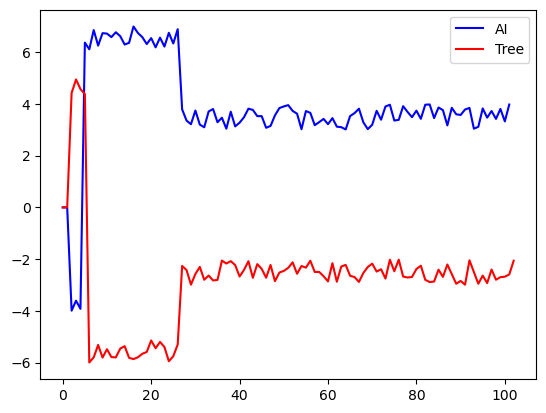

In [94]:
import numpy as np
import matplotlib.pyplot as pt


# visualize learning curves on train/test data
pt.plot(curve[0][0:j+1], 'b-')
pt.plot(curve[1][0:j+1], 'r-')
#pt.plot([0, len(curve[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
pt.legend(["AI","Tree"])
pt.show()

In [84]:
#This method is for game that can be customized by the user

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
b1 = "8/8/7"+s+"/8/8/r7/1kr5/7K"
b2 = "8/8/8/8/B7/b6"+s+"/1kp5/7K"
b3 = "full board"
b4 = "8/1kr5/7"+s+"/8/8/r7/7K/8"
b5 = "8/7k/p1p2p2p/7"+s+"/8/r7/1K1n4/8"
#b6= "8/8/8/8/8/8/7Q/5k1K"
print("select which problem instance board you want\n b1: ",b1,"\n b2:",b2,"\n b3: ",b3,"\n b4:",b4,"\n b5: ",b5)
b6 = input("Write b1 or b2 or b3 or b4 or b5")
if(b6=="b1"):
    board = chess.Board(b1)
elif(b6=="b2"):
    board = chess.Board(b2) 
elif(b6=="b3"):
    board = chess.Board()
elif(b6=="b4"):
    board = chess.Board(b4)
else:
    board = chess.Board(b6)
score=0

#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
#display_board(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
base1="AI"
base2="AI"
white = 1

if(choice==3):
    base1 = "Tree"

elif (choice==5):
    base2="NN"
   # white=0
elif(choice==4):
    base1="Tree"
    base2 = "Tree"
moves = 0
pgn = []
game = chess.pgn.Game()
evaluations = []
sm = 0
cnt = 0
curve  = [ [0]*2 for i in range(2)]
# curve = np.zeros((5,100,1000,2))

j=0
while((not board.is_game_over())):
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()
    if(white==1):
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    elif(choice==2 and white==0):
        print("input format should be something like a2, b6, g3, first one is row, second one is colum")
        print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
        to=input("Write where you want to go = ")
        frm = input("write from where you want to move = ")
        result=frm+to
    elif(choice==5 and white==0):
        start = time.time()
        matrix = make_matrix(board.copy())
        translated = np.array(translate(matrix,chess_dict))
        print(model.predict(translated.reshape(1,8,8,12)))
        clear_output()
        move = calculate_move(15,board,10)
        #print("time taken for nn in iteration ",j,(time.time()-start))
    else:
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    try:
        board.push_san(result)

    except:
        print(result)
        print("invalid move. game over")
        break
    #print(result)
    score = staticAnalysis(board,white)
    col="BLACK"
    if(white):
        col="WHITE"
    print("score for ",col,"= ",score)

    curve[white].append(score)
    pgn.append(result)
    white ^= 1
    j+=1

    moves+=1
    #info = engine.analyse(board, chess.engine.Limit(depth=24))
    #evaluat += info['score'].white()
    print(board)

    print("-----------move done-----------")

print(" ".join(pgn))
print()
#{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

#print(info)
#print(evaluations)
#We are showing score for each player after each move, so in final result the score is only based on the winner.
#If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
print(board.result())

game.headers["Result"] = board.result()


We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?
p or P or Q or R or q or b . Only write the letter 
p
select which problem instance board you want
 b1:  8/8/7p/8/8/r7/1kr5/7K 
 b2: 8/8/8/8/B7/b6p/1kp5/7K 
 b3:  full board 
 b4: 8/1kr5/7p/8/8/r7/7K/8 
 b5:  8/7k/p1p2p2p/7p/8/r7/1K1n4/8
Write b1 or b2 or b3 or b4 or b5b1
. . . . . . . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
r . . . . . . .
. k r . . . . .
. . . . . . . K
Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?
 write 1 or 2 or 3 or 4 or 5= 2
time taken to iteration 0 2.4816973209381104
score for  WHITE =  -6.160085488115614
. . . . . . . .
. . . . . . . .
. . . . . . . p
. . . . . . . .
. . . . . . . .
r . . . . . . .
. k r . . . . .
. . . . . . K .
-----------move done-----------
input format should be somethin

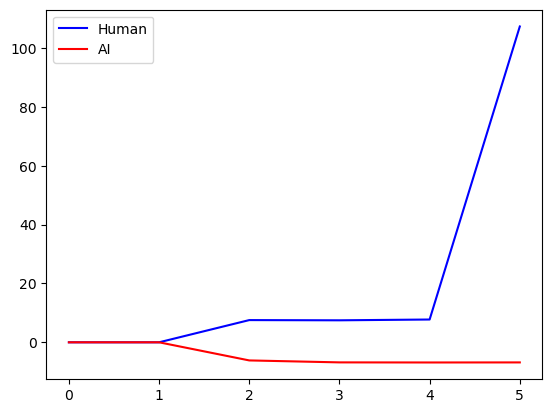

In [87]:
import numpy as np
import matplotlib.pyplot as pt

# visualize learning curves on train/test data
pt.plot(curve[0][0:j], 'b-')
pt.plot(curve[1][0:j], 'r-')
#pt.plot([0, len(curve[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
pt.legend(["Human","AI"])
pt.show()

In [79]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install keras

In [ ]:
pip install tensorflow


In [ ]:
pip uninstall eventlet

In [ ]:
#This method is for game that can be customized by the user

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
b1 = "8/8/7"+s+"/8/8/r7/1kr5/7K"
b2 = "8/8/8/8/B7/b6"+s+"/1kp5/7K"
b3 = "full board"
b4 = "8/1kr5/7"+s+"/8/8/r7/7K/8"
b5 = "8/7k/p1p2p2p/7"+s+"/8/r7/1K1n4/8"
#b6= "8/8/8/8/8/8/7Q/5k1K"
print("select which problem instance board you want\n b1: ",b1,"\n b2:",b2,"\n b3: ",b3,"\n b4:",b4,"\n b5: ",b5)
b6 = input("Write b1 or b2 or b3 or b4 or b5")
if(b6=="b1"):
    board = chess.Board(b1)
elif(b6=="b2"):
    board = chess.Board(b2) 
elif(b6=="b3"):
    board = chess.Board()
elif(b6=="b4"):
    board = chess.Board(b4)
else:
    board = chess.Board(b6)
score=0

#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
#display_board(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
base1="Tree"
base2="Tree"
white = 1

if(choice==3):
    base1 = "Tree"

elif (choice==5):
    base2="NN"
    #white=0
elif(choice==4):
    base1="Tree"
    base2 = "Tree"
moves = 0
pgn = []
game = chess.pgn.Game()
evaluations = []
sm = 0
cnt = 0
curve  = [ [0]*2 for i in range(2)]
# curve = np.zeros((5,100,1000,2))

j=0
while((not board.is_game_over())):
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()
    if(white==1):
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    elif(choice==2 and white==0):
        print("input format should be something like a2, b6, g3, first one is row, second one is colum")
        print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
        to=input("Write where you want to go = ")
        frm = input("write from where you want to move = ")
        result=frm+to
    elif(choice==5 and white==0):
        start = time.time()
        #matrix = make_matrix(board.copy())
        translated = np.array(translate(matrix,chess_dict))
        #print(model.predict(translated.reshape(1,8,8,12)))
        #clear_output()
        #result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        result = calculate_move(10,board,10)
        #print("time taken for nn in iteration ",j,(time.time()-start))
    else:
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    try:
        board.push_san(result)

    except:
        print(result)
        print("invalid move. game over")
        break
    #print(result)
    score = staticAnalysis(board,white)
    col="BLACK"
    if(white):
        col="WHITE"
    print("score for ",col,"= ",score)

    curve[white].append(score)
    pgn.append(result)
    white ^= 1
    j+=1

    moves+=1
    #info = engine.analyse(board, chess.engine.Limit(depth=24))
    #evaluat += info['score'].white()
    print(board)

    print("-----------move done-----------")

print(" ".join(pgn))
print()
#{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

#print(info)
#print(evaluations)
#We are showing score for each player after each move, so in final result the score is only based on the winner.
#If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
print(board.result())

game.headers["Result"] = board.result()
